# Parallel Workflow Experiment

In [1]:
import json
import os
import pdb
import random
import re
import time
from typing import Any, Callable, Dict, List, Optional, Tuple, Type, Union

import matplotlib.pyplot as plt
import PIL
import requests
from diskcache import Cache
from openai import OpenAI
from PIL import Image
from termcolor import colored

import autogen
from autogen import Agent, AssistantAgent, ConversableAgent, UserProxyAgent
from autogen.agentchat.contrib.img_utils import _to_pil, get_image_data, get_pil_image, gpt4v_formatter
from autogen.agentchat.contrib.multimodal_conversable_agent import MultimodalConversableAgent

In [2]:
config_list_4v = autogen.config_list_from_json(
    "OAI_CONFIG_LIST",
    filter_dict={
        "model": ["gpt-4", "gpt-4o"],
    },
)

config_list_gpt4 = autogen.config_list_from_json(
    "OAI_CONFIG_LIST",
    filter_dict={
        "model": ["gpt-4", "gpt-4o"],
    },
)

config_list_dalle = autogen.config_list_from_json(
    "OAI_CONFIG_LIST",
    filter_dict={
        "model": ["dalle"],
    },
)

gpt4_llm_config = {"config_list": config_list_gpt4, "cache_seed": 42}

In [3]:
def dalle_call(client: OpenAI, model: str, prompt: str, size: str, quality: str, n: int) -> str:
    # Function implementation...
    cache = Cache(".cache/")  # Create a cache directory
    key = (model, prompt, size, quality, n)
    if key in cache:
        return cache[key]

    # If not in cache, compute and store the result
    response = client.images.generate(
        model=model,
        prompt=prompt,
        size=size,
        quality=quality,
        n=n,
    )
    image_url = response.data[0].url
    img_data = get_image_data(image_url)
    cache[key] = img_data

    return img_data

In [4]:
def extract_img(agent: Agent) -> PIL.Image:
    last_message = agent.last_message()["content"]

    if isinstance(last_message, str):
        img_data = re.findall("<img (.*)>", last_message)[0]
    elif isinstance(last_message, list):
        # The GPT-4V format, where the content is an array of data
        assert isinstance(last_message[0], dict)
        img_data = last_message[0]["image_url"]["url"]

    pil_img = get_pil_image(img_data)
    return pil_img

In [5]:
class DALLEAgent(ConversableAgent):
    def __init__(self, name, llm_config: dict, **kwargs):
        super().__init__(name, llm_config=llm_config, **kwargs)

        try:
            config_list = llm_config["config_list"]
            api_key = config_list[0]["api_key"]
        except Exception as e:
            print("Unable to fetch API Key, because", e)
            api_key = os.getenv("OPENAI_API_KEY")
        self._dalle_client = OpenAI(api_key=api_key)
        self.register_reply([Agent, None], DALLEAgent.generate_dalle_reply)

    def send(
        self,
        message: Union[Dict, str],
        recipient: Agent,
        request_reply: Optional[bool] = None,
        silent: Optional[bool] = False,
    ):
        super().send(message, recipient, request_reply, silent=True)

    def generate_dalle_reply(self, messages: Optional[List[Dict]], sender: "Agent", config: Optional[Dict]):
        client = self._dalle_client if config is None else config
        if client is None:
            return False, None
        if messages is None:
            messages = self._oai_messages[sender]

        prompt = messages[-1]["content"]
        img_data = dalle_call(
            client=client,
            model="dall-e-3",
            prompt=prompt,
            size="1024x1024",
            quality="standard",
            n=1,
        )

        img_data = _to_pil(img_data)  # Convert to PIL image

        # Return the OpenAI message format
        return True, {"content": [{"type": "image_url", "image_url": {"url": img_data}}]}

In [6]:
class DALLESituationAgent(ConversableAgent):
    def __init__(self, name, llm_config: dict, **kwargs):
        super().__init__(name, llm_config=llm_config, **kwargs)

        try:
            config_list = llm_config["config_list"]
            api_key = config_list[0]["api_key"]
        except Exception as e:
            print("Unable to fetch API Key, because", e)
            api_key = os.getenv("OPENAI_API_KEY")
        self._dalle_client = OpenAI(api_key=api_key)
        self.register_reply([Agent, None], DALLESituationAgent.generate_dalle_reply)

    def send(
        self,
        message: Union[Dict, str],
        recipient: Agent,
        request_reply: Optional[bool] = None,
        silent: Optional[bool] = False,
    ):

        super().send(message, recipient, request_reply, silent=True)

    def generate_dalle_reply(self, messages: Optional[List[Dict]], sender: "Agent", config: Optional[Dict]):
        client = self._dalle_client if config is None else config
        if client is None:
            return False, None
        if messages is None:
            messages = self._oai_messages[sender]

        prompt = messages[-1]["content"]
        img_data = dalle_call(
            client=client,
            model="dall-e-3",
            prompt=prompt,
            size="1024x1024",
            quality="hd",
            n=1,
        )

        img_data = _to_pil(img_data)  # Convert to PIL image

        # Return the OpenAI message format
        return True, {"content": [{"type": "image_url", "image_url": {"url": img_data}}]}

In [13]:
class DalleCreator(AssistantAgent):
    def __init__(self, n_iters=2, **kwargs):
        super().__init__(**kwargs)
        self.register_reply([Agent, None], reply_func=DalleCreator._reply_user, position=0)
        self._n_iters = n_iters

    def _reply_user(self, messages=None, sender=None, config=None):
        if all((messages is None, sender is None)):
            error_msg = f"Either {messages=} or {sender=} must be provided."
            logger.error(error_msg)  # noqa: F821
            raise AssertionError(error_msg)

        if messages is None:
            messages = self._oai_messages[sender]

        img_prompt = messages[-1]["content"]

        # Define the agents
        self.ConceptAgent = ConversableAgent(
            name="ConceptAgent",
            system_message="""
            You are an experienced character designer specialized in creating innovative and engaging character concepts.

            ### Instruction:
            Your task is to create an appealing and detailed character concept based on the initial prompt. Your output should include:

            - **Backstory**: Craft a detailed backstory for the character, including their origins, key life events, significant relationships, hobbies, and any unique experiences that shaped their personality.
            - **Personality Traits**: Determine descriptors like brave, comical, shy, and adventurous that will influence their actions and dialogue.
            - **Motivations**: Establish the driving goals, desires, and conflicts that propel the character through the story. Motivations inform their arc.
            - **Mannerisms**: Come up with signature habitual behaviors, gestures, postures, and quirks that reflect personality.

            ### Format:
            - Personality Traits: 
            - Backstory:
            - Motivations:
            - Mannerisms: 

            """,
            llm_config={"config_list": config_list_4v, "max_tokens": 500},
            human_input_mode="NEVER",
            max_consecutive_auto_reply=3,
        )
        self.SketchAgent = ConversableAgent(
            name="SketchAgent", 
            system_message="""
            You are an experienced character designer with a focus on creating detailed and engaging character sketches based on concepts provided by ConceptAgent.

### Instruction:
Your task is to create black-and-white sketches of the character, emphasizing a clear and dynamic silhouette, a pose that reflects their personality, and key features that align with their role in the story.

### Output:
Your final output should include:

1. **Sketch Description:** Describe the sketch in detail, covering the character's silhouette, pose, expression, and key features.

2. **Design Rationale:** Explain the reasons behind your design choices, such as how they reflect the character's personality and role within the story.

### Additional Notes:
- Prioritize clarity in the silhouette and proportions to ensure the design is easily understandable from all angles.
""",
            llm_config={"config_list": config_list_4v, "max_tokens": 1000}, 
            human_input_mode="NEVER",
            max_consecutive_auto_reply=3,
        )

        self.ColorAgent = ConversableAgent(
            name="ColorAgent", 
            system_message="""
You are a skilled character designer specializing in adding color to character sketches. Your task is to select a color scheme that reflects the character’s concept and enhances their visual impact.

### Requirements:
1. **Color Selection**: Choose 3-5 core colors that reflect the character’s personality, backstory, and role, and make the character visually striking.
2. **Silhouette Recognition**: Ensure the colors enhance the character’s silhouette, making them distinct and easily recognizable.
3. **Balance and Flexibility**: The color scheme should be distinct yet adaptable, working well in different lighting and environments.

### Output:
Provide the following details:

1. The core colors selected for the character.
2. How the colors combine and interact.
3. Why these colors were chosen and how they reflect the character's personality and backstory.

### Additional Notes:
- Prioritize color combinations that enhance the character's design and visual storytelling.
- Ensure the colors are both aesthetically pleasing and functional, supporting the character's role and narrative.
""",
            llm_config={"config_list": config_list_4v, "max_tokens": 1000}, 
            human_input_mode="NEVER",
            max_consecutive_auto_reply=3,
        )

        self.RefineAgent = ConversableAgent(
            name="RefineAgent", 
            system_message="""
            You are a skilled character designer focused on refining and enhancing character details to achieve the highest quality and consistency across all views.

### Requirements:
Refine and enhance subtle details like textures, shading, and fine features to improve the character's overall visual quality and appeal.

### Output:
Provide the following details:

1. The enhancements made to the character’s details, such as textures, shading, and fine features.
2. The reason for these enhancements, explaining how they improve the character's visual quality and consistency.

### Additional Notes:
- Ensure alignment and proportion of details are consistent across all views for a uniform and polished design.
- Focus on enhancements that elevate the character's visual impact, making the design both functional and aesthetically pleasing.
""",
            llm_config={"config_list": config_list_4v, "max_tokens": 1000}, 
            human_input_mode="NEVER",
            max_consecutive_auto_reply=3,
        )

        self.IntegrateTextAgent = ConversableAgent(
            name="IntegrateTextAgent", 
            system_message="""
            You are a skilled character designer tasked with integrating and summarizing all key aspects of character design into a cohesive and concise prompt.

### Requirements:
Create an integrated prompt that includes the following elements, focusing on visual clarity and detail:

1. **Character Concept:** Summarize the character’s core idea, personality, and role in the story. Include any relevant backstory that influences their appearance.
2. **Sketch Description:** Provide a detailed description of the character’s silhouette, pose, and key features. Emphasize distinctive visual traits that make the character unique.
3. **Color Choices:** List the core colors selected and describe how they should be applied to different parts of the character. Explain how these colors reflect the character’s personality and enhance their visual impact.
4. **Refinement Details:** Summarize the enhancements made to textures, shading, and fine features. Describe how these details contribute to the character’s overall realism and appeal.

### Output:
- The final integrated prompt should be no more than 300 words.
- Ensure that the prompt is visually descriptive and specific, enabling DALL-E 3 to generate a highly accurate and detailed character image.
- Use clear and direct language, focusing on elements that are crucial for visual rendering.

            """,
            llm_config={"config_list": config_list_4v, "max_tokens": 1000}, 
            human_input_mode="NEVER",
            max_consecutive_auto_reply=3,
        )


        self.IntegrateImageAgent = DALLESituationAgent(
            name="IntegrateImageAgent", 
            system_message="""
            You are a skilled character designer tasked with creating a high-quality, consistent character based on the detailed prompt provided by IntegrateTextAgent. Your output will be used to generate images with DALL-E 3.

### Requirements:
Accurately depict all details described in the integrated prompt to create an attractive and cohesive character design.

### Output:
Your final output should include three views of the character, each in full color and with high attention to detail:

1. **Full-Body ‘A’ Pose View (Head to Toe)**: Generate a full-body image of the character in a neutral 'A' pose. Ensure that all details, including colors, textures, and features, are consistent and contribute to the character’s overall visual appeal.
2. **Orthographic Front View**: Create a front-facing view of the character, focusing on maintaining detail accuracy and quality. Ensure that all design elements from the full-body view are correctly aligned and represented.
3. **Orthographic Back View**: Generate a back-facing view of the character. Match the quality and detail level of the front and full-body views, ensuring seamless consistency across all angles.

### Additional Notes:
- Ensure that all views are consistent in quality, color application, and design details to create a cohesive and visually striking character.
- Use precise and vivid descriptions to guide DALL-E 3 in rendering each view with high accuracy and appeal.
            """,
            llm_config={"config_list": config_list_dalle}, max_consecutive_auto_reply=0,
        )

        self.SituationAgent = DALLESituationAgent("""
You are an experienced character designer specializing in creating dynamic poses and situations that align with the character’s storyline.

### Requirements:
1. **Consistency**: Maintain high consistency in the character’s appearance and details as provided by RefineAgent. Ensure that all visual elements align with the input image.
2. **Scenario Accuracy**: Depict the character in scenarios that accurately reflect their personality, backstory, and role within the story. The poses and situations should be expressive and true to the character's nature.
3. **Clean Output**: Ensure the final images are free of any words, text, or unintended artifacts.

### Output:
Your output should include multiple character poses and situations that are consistent with the character's design and narrative.

### Additional Notes:
- Pay special attention to the character's body language and expressions to ensure they convey the intended emotions and story context.
- Ensure that the scenarios are visually engaging and enhance the overall narrative of the character.
                """,
            llm_config={"config_list": config_list_dalle}, max_consecutive_auto_reply=0,
        )

        # self.TestAgent = DALLEAgent(
        #     name="TestAgent", 
        #     system_message="""You need to identify and remove images that could disrupt the consistency of the character, 
        #     such as imprecise details or significant variations.
        #     """,
        #     llm_config={"config_list": config_list_dalle}, max_consecutive_auto_reply=0,
        # )

        # Step 1: Generate character concept
        concept_prompt = f"""{img_prompt} Create a character concept based on the prompt provided."""
        self.send(message={"content": concept_prompt, "system_message": self.ConceptAgent.system_message}, recipient=self.ConceptAgent, request_reply=True)
        concept_response = self._oai_messages[self.ConceptAgent][-1]["content"]

        # Step 2: Generate sketches, add colors, and refine in parallel
        sketch_prompt = f"""{concept_response} Create a black-and-white sketch and describe it."""
        self.send(message={"content": sketch_prompt, "system_message": self.SketchAgent.system_message}, recipient=self.SketchAgent, request_reply=True)

        color_prompt = f"""{concept_response} Select the primary color palette for the character."""
        self.send(message={"content": color_prompt, "system_message": self.ColorAgent.system_message}, recipient=self.ColorAgent, request_reply=True)

        refine_prompt = f"""{concept_response} Define the details of the character."""
        self.send(message={"content": refine_prompt, "system_message": self.RefineAgent.system_message}, recipient=self.RefineAgent, request_reply=True)

        # Wait for all operations to complete and gather responses
        while True:
            try:
                sketch_response = self._oai_messages[self.SketchAgent][-1]["content"]
                color_response = self._oai_messages[self.ColorAgent][-1]["content"]
                refine_response = self._oai_messages[self.RefineAgent][-1]["content"]
                break  # If all responses are received, exit the loop
            except (IndexError, KeyError):
                continue  # Keep checking until all responses are available

        # Step 3: Summarize the character concept, sketch, color, and refine details into a whole prompt
        Integrate_text_prompt = f"""Based on the following information:
        - Character Concept: {concept_response}
        - Sketch Description: {sketch_response}
        - Color Choices: {color_response}
        - Refinement Details: {refine_response}

        Integrate and summarize all these aspects to create a cohesive prompt for character design.
        No more than 400 words.
        """
        self.send(message={"content": Integrate_text_prompt, "system_message": self.IntegrateTextAgent.system_message}, recipient=self.IntegrateTextAgent, request_reply=True)
        Integrate_text_response = self._oai_messages[self.IntegrateTextAgent][-1]["content"]

        # Step 4: Generate the final character design
        Integrate_image_prompt = f"""Follow the prompt: {Integrate_text_response} 
        to create a consistent, high-quality, and visually appealing character.
        """
        self.send(message={"content": Integrate_image_prompt, "system_message": self.IntegrateImageAgent.system_message}, recipient=self.IntegrateImageAgent, request_reply=True)
        Integrate_img = extract_img(self.IntegrateImageAgent)

        Integrate_img.save("Integrate_img.png")
        plt.imshow(Integrate_img)
        plt.title("Integrate Image")
        plt.axis("off")
        plt.show()

        # # Step 5: Generate different poses and situations
        # situation_prompt = f"""
        # Generate six different poses and situations of the character in the following image <img Integrate_img.png> based on the description: {Integrate_text_response}. 
        # Ensure the character should stay precise consistency and high quality aligned with the concept.
        # """
        # self.send(message={"content": situation_prompt, "system_message": self.SituationAgent.system_message}, recipient=self.SituationAgent, request_reply=True)
        # situation_img = extract_img(self.SituationAgent)
        # situation_img.save("situation_img.png")
        # plt.imshow(situation_img)
        # plt.title("Situation Image")
        # plt.axis("off")
        # plt.show()

        # Step 5: Generate different poses and situations
        # for i in range(self._n_iters):
        #     situation_text_prompt = f"""Generate one situation of the character in the following image <img refine_img.png> based on the concept: {concept_response}.
        #     Please use simple word and keep the description under 100 words"""
        #     self.send(message={"content": situation_text_prompt, "system_message": self.SituationTextAgent.system_message}, recipient=self.SituationTextAgent, request_reply=True)
        #     feedback = self._oai_messages[self.SituationTextAgent][-1]["content"]
        #     situation_img_prompt = f"""Apply the character in the following image <img refine_img.png> into the situation:{feedback}.
        #     Ensure the character is consistent with that in image and accurately depicted in the specified scenario.
        #     Ensure there are no words or text in the image.
        #     """
        #     self.send(message={"content": situation_img_prompt, "system_message": self.SituationImgAgent.system_message}, recipient=self.SituationImgAgent, request_reply=True)
        #     situation_img = extract_img(self.SituationImgAgent)
        #     situation_img.save(f"situation_img_{i}.png")
        #     plt.imshow(situation_img)
        #     plt.title(f"Situation Image {i}")
        #     plt.axis("off")
        #     plt.show()
        #     print(f"Image {i} PLOTTED")

        return True, "result.jpg"

User (to DALLE Creator!):

Design an elf cartoon style.

--------------------------------------------------------------------------------
DALLE Creator! (to ConceptAgent):

Design an elf cartoon style. Create a character concept based on the prompt provided.

--------------------------------------------------------------------------------
ConceptAgent (to DALLE Creator!):

### Character Concept: Elowen, the Enigmatic Elf

#### Personality Traits:
- Adventurous
- Calculating
- Charismatic
- Loyal
- Inquisitive
- Mischievous

#### Backstory:
Elowen was born in the mystical forest of Aranthal to a lineage of skilled elven enchanters. Her parents, renowned for their magical abilities, were revered by their community. As a child, Elowen showed an innate talent for enchantment, surpassing her elders in creating intricate spells and charms.

At age 100, considered adolescence for elves, Elowen’s life took a pivotal turn when she accidentally activated an ancient runestone, triggering a series

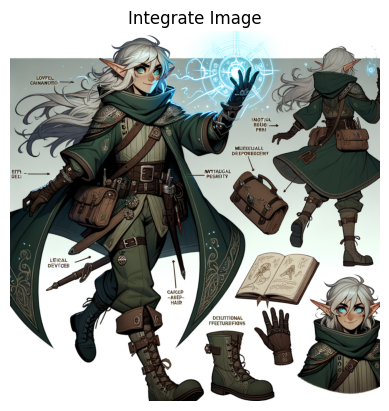

DALLE Creator! (to User):

result.jpg

--------------------------------------------------------------------------------


ChatResult(chat_id=None, chat_history=[{'content': 'Design an elf cartoon style.', 'role': 'assistant'}, {'content': 'result.jpg', 'role': 'user'}], summary='result.jpg', cost={'usage_including_cached_inference': {'total_cost': 0}, 'usage_excluding_cached_inference': {'total_cost': 0}}, human_input=[])

In [14]:
creator = DalleCreator(
    name="DALLE Creator!",
    max_consecutive_auto_reply=0,
    system_message="Help me coordinate generating image",
    llm_config=gpt4_llm_config,
)

user_proxy = UserProxyAgent(name="User", human_input_mode="NEVER", max_consecutive_auto_reply=0)

user_proxy.initiate_chat(
    creator, message="""Design an elf cartoon style."""
)